# Narrativas Visuais: A Arte de Contar Histórias com Dados  
## Série Histórica CONAB - Cana-de-Açúcar ou Café

**Integrantes:**  
- Juliano Eleno Silva Pádua 800812

**Disciplina:** Processamento e Visualização de Dados
**Data:** 24/09/2025

**Fonte de dados:** Portal de Informações Agropecuárias - CONAB. Downloadas feitos automaticamente neste notebook.


## Introdução

Neste projeto, escolhemos utilizar **séries históricas agropecuárias da CONAB** (Cana-de-Açúcar ou Café). O usuário seleciona a série desejada, e o notebook baixa e processa a base diretamente do **Portal de Informações Agropecuárias** da CONAB

- **Nome o conjunto de dados:** Série Histórica (Cana-de-Açúcar **ou** Café) - CONAB  
- **Link do portal:** https://portaldeinformacoes.conab.gov.br/download-arquivos.html  
- **Link direto será detectado automaticamente** (sem hard-code) na seção de pré-processamento.

**Razão da escolha:** As cadeias de **cana** (açúcar/etanol) e **café** são pilares do agro brasileiro, com impacto macroeconômico, energético e regional. Essas séries permitem explorar narrativas de produção, volatilidade e tendências de longo prazo, enriquecendo a interpretação com técnicas de time series e até indicadores técnicos (média móvel, EMA, Bandas de Bollinger, MACD) para analisar momentum e variação - com o devido cuidado de interpretação em dados não-financeiros.

**Narrativa proposta:** “Como evoluíram as safras ao longo do tempo? Quais estados mais contribuem? Dá para identificar períodos de expansão/queda e mudanças de tendência usando suavizações e bandas de variação?”


In [ ]:
!pip -q install ipywidgets==8.1.3 plotly==5.22.0

from IPython.display import display, Markdown, HTML
from io import StringIO
import requests, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import ipywidgets as widgets
import textwrap
import sys

plt.style.use("seaborn-v0_8")
sns.set_context("talk")
pd.set_option("display.max_colwidth", 120)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00


## Metodologia

**Ferramentas:** Python (pandas, numpy, matplotlib/seaborn/plotly), requests, ipywidgets.

**Coleta automática:** O notebook acessa a página de *Downloads de Arquivos* da CONAB e faz o scrapping para as séries históricas de Cana e de Café, evitando dependência de URLs fixas.

**Pré-processamento (em resumo):**
1. Leitura do TXT (separador `;`) com `dtype=str` para preservar formato BR.
2. Limpeza de strings (trim) e padronização de decimais (`','` → `'.'`).
3. Conversão de numéricos com `to_numeric` tolerante a erros.
4. Parsing de safra (`AAAA/BB`), criando `safra_inicio` e `safra_fim`.
5. Agregação por safra e/ou UF conforme a visualização.
6. Cálculo de indicadores (SMA, EMA, Bandas de Bollinger, MACD) sobre a série total nacional para facilitar leitura de tendência/volatilidade.

> Observação: Séries agro têm revisões/levantamentos; para evitar dupla contagem, usamos deduplicações simples e agregações por safra/UF.

In [ ]:
BASE = "https://portaldeinformacoes.conab.gov.br"
URL = f"{BASE}/download-arquivos.html"

resp = requests.get(URL, timeout=30)
resp.raise_for_status()
html = resp.text

# âncoras que apontam para arquivos .txt do diretório /downloads/arquivos/
pattern = r'href="(/downloads/arquivos/[^"]+\.txt)"'
paths = re.findall(pattern, html)

# organizar candidatos:
links = {p.split("/")[-1].lower(): BASE + p for p in paths}

# mapeiamos os nomes-chave
cana_key = next((k for k in links if "seriehistorica" in k and "cana" in k), None)
cafe_key = next((k for k in links if "seriehistorica" in k and "cafe" in k), None)

dataset_links = {}
if cana_key:
    dataset_links["cana"] = links[cana_key]
if cafe_key:
    dataset_links["cafe"] = links[cafe_key]

display(Markdown("**Links detectados:**"))
for k, v in dataset_links.items():
    display(Markdown(f"- **{k.title()}**: {v}"))

if not dataset_links:
    raise RuntimeError("Nenhum link de série histórica (cana/café) encontrado. Verifique a página da CONAB.")


**Links detectados:**

- **Cana**: https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaCana.txt

- **Cafe**: https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaCafe.txt

## Escolha da Série

Selecione **Cana** ou **Café**. As análises e gráficos a seguir se adaptarão automaticamente.


In [ ]:
# Seletor de serie
opcoes = ["cana" if "cana" in dataset_links else None, "cafe" if "cafe" in dataset_links else None]
opcoes = [o for o in opcoes if o is not None]

serie_dd = widgets.Dropdown(options=opcoes, value=opcoes[0], description="Série:")
display(serie_dd)

def get_serie_escolhida():
    val = serie_dd.value if isinstance(serie_dd.value, str) else None
    if val in dataset_links:
        return val
    # fallback
    x = input(f"Digite sua série ({'/'.join(opcoes)}): ").strip().lower()
    if x in dataset_links:
        return x
    raise ValueError("Série inválida.")



Dropdown(description='Série:', options=('cana', 'cafe'), value='cana')

In [ ]:
# Baixar TXT, ler e limpar (PT-BR → numérico)
serie = get_serie_escolhida()
url = dataset_links[serie]
display(Markdown(f"**Série escolhida:** `{serie}`  \n**URL detectada:** {url}"))

r = requests.get(url, timeout=60)
r.raise_for_status()

# Tentativa UTF-8 e fallback Latin-1
text = None
for enc in ["utf-8", "latin-1", "cp1252"]:
    try:
        text = r.content.decode(enc)
        break
    except UnicodeDecodeError:
        continue
if text is None:
    raise UnicodeDecodeError("Falha de decodificação: tente baixar manualmente.")

raw = StringIO(text)

# Leitura como string para limpeza customizada
df = pd.read_csv(raw, sep=";", dtype=str, engine="python")

# Strip geral (sem applymap): aplica .str.strip() apenas nas colunas-objeto
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].str.strip()

# Função para tentar converter colunas numéricas com vírgula decimal (sem errors='ignore')
def maybe_to_numeric(col: pd.Series) -> pd.Series:
    if col.dtype != object:
        return col

    # Heurística rápida: se maioria dos primeiros valores parecem numéricos, tentamos converter
    sample = (
        col.dropna().astype(str).head(100)
        .str.replace(r"[^0-9,.\-]", "", regex=True)
    )
    frac_numericish = (sample.str.len() > 0).mean()
    if frac_numericish < 0.6:
        return col  # mantém como está

    # vírgula → ponto e tentativa de conversão
    c = col.str.replace(",", ".", regex=False)
    converted = pd.to_numeric(c, errors="coerce")

    # se a conversão aproveitou uma parcela razoável dos dados, ficamos com ela
    non_na_ratio = (converted.notna().sum() / max(len(converted), 1))
    if non_na_ratio >= 0.5:
        return converted
    else:
        return col

df = df.apply(maybe_to_numeric)

display(Markdown("### Amostra da base (5 linhas)"))
display(df.head())
display(Markdown(f"- **Nº de linhas (registros):** {len(df):,}  \n- **Nº de atributos (colunas):** {df.shape[1]}"))


**Série escolhida:** `cana`  
**URL detectada:** https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaCana.txt

### Amostra da base (5 linhas)

,ano_agricola,dsc_safra_previsao,uf,produto,id_produto,area_plantada_mil_ha,producao_mil_t,dsc_situacao_levantamento,producao_acucar_mil_t,producao_etanol_anidro_mil_l,producao_etanol_hidratado_mil_l,producao_etanol_total_mil_l,produtcao_atr_kg_t
0,2005/06,UNICA,AL,CANA DE ACUCAR,4238,402.1,23110.7,PREVISAO,2077.4,294667.9,278710.6,573378.5,137.2
1,2005/06,UNICA,AM,CANA DE ACUCAR,4238,3.8,194.4,PREVISAO,22.7,486.3,367.2,853.5,130.2
2,2005/06,UNICA,BA,CANA DE ACUCAR,4238,55.0,3367.7,PREVISAO,242.3,229000.0,51675.3,280675.3,221.5
3,2005/06,UNICA,CE,CANA DE ACUCAR,4238,35.1,1773.3,PREVISAO,0.0,569.3,27879.2,28448.5,27.2
4,2005/06,UNICA,ES,CANA DE ACUCAR,4238,64.4,4243.4,PREVISAO,66.2,172000.9,79486.4,251487.3,119.6


- **Nº de linhas (registros):** 451  
- **Nº de atributos (colunas):** 13

### E essa tabela...?

Ao observar a tabela acima, surge uma questão importante: o que exatamente conseguimos interpretar apenas olhando esse recorte cru dos dados?
De fato, enxergamos nomes de colunas, alguns números e rótulos, mas não fica claro quais são os padrões, as tendências ou mesmo a relevância de cada atributo. A densidade de informação é alta, mas a utilidade prática, neste formato, é bastante limitada.  
Em outras palavras: a tabela em si não nos conta uma história. Ela é apenas o ponto de partida para as etapas seguintes de pré-processamento e visualização.  
Somente a tabela não nos fornece suficiente informação. Precisamos avançar para gráficos e análises que realmente traduzam a base em insights compreensíveis.

In [ ]:
tipos = df.dtypes.to_dict()

def faixa(col):
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        return f"[{pd.to_numeric(s, errors='coerce').min()}, {pd.to_numeric(s, errors='coerce').max()}]"
    elif s.nunique() <= 20:
        return f"discreto (até 20 categorias, p.ex.: {sorted(s.dropna().unique()[:5])}...)"
    return "discreto/contínuo (avaliar)"

linhas = []
for c, t in tipos.items():
    linhas.append({
        "atributo": c,
        "tipo_pandas": str(t),
        "faixa_ou_natureza": faixa(c)
    })
dic = pd.DataFrame(linhas)
display(Markdown("### Dicionário de dados (automático)"))
display(dic)


### Dicionário de dados (automático)

,atributo,tipo_pandas,faixa_ou_natureza
0,ano_agricola,object,discreto/contínuo (avaliar)
1,dsc_safra_previsao,object,"discreto (até 20 categorias, p.ex.: ['UNICA']...)"
2,uf,object,discreto/contínuo (avaliar)
3,produto,object,"discreto (até 20 categorias, p.ex.: ['CANA DE ACUCAR']...)"
4,id_produto,int64,"[4238, 4238]"
5,area_plantada_mil_ha,float64,"[0.0, 4773.1]"
6,producao_mil_t,float64,"[0.0, 383409.5]"
7,dsc_situacao_levantamento,object,"discreto (até 20 categorias, p.ex.: ['PREVISAO']...)"
8,producao_acucar_mil_t,float64,"[0.0, 28261.9]"
9,producao_etanol_anidro_mil_l,float64,"[0.0, 6736041.0]"


### Identificação de colunas-chave

Nesta etapa, buscamos identificar **duas colunas essenciais** para a narrativa:

1. **Coluna de ano/safra**  
   - O código procura automaticamente algum atributo com termos como `"ano"` e `"agric"`.  
   - Caso não encontre, assume a primeira coluna da base.  
   - A seguir, convertemos valores no formato `2005/06` em um ano de referência (`safra_fim = 2006` e `safra_inicio = 2005`).  
   - Isso garante que possamos trabalhar com a série temporal de forma numérica e contínua.

2. **Coluna de produção**  
   - Fazemos uma busca por nomes que contenham `"produc"` junto a unidades (`mil t`, `sacas`, `L` etc.).  
   - Caso exista mais de uma opção, priorizamos colunas comuns (como `producao_mil_t` para Cana).  
   - Se ainda assim não for encontrada, usamos uma heurística: a **primeira coluna numérica com maior soma**.

Ao final, temos duas variáveis definidas automaticamente:
- `safra_fim`: ano final da safra.  
- `col_prod`: a métrica principal de produção.

Essas escolhas são cruciais porque servirão de **base para todas as visualizações posteriores** (linha temporal, top UFs, indicadores). Sem isso, seria inviável padronizar as análises, já que cada arquivo da CONAB traz nomenclaturas ligeiramente diferentes.


In [ ]:
# tenta identificar coluna de 'ano_agricola'
cand_ano = [c for c in df.columns if "ano" in c.lower() and "agric" in c.lower()]
col_ano = cand_ano[0] if cand_ano else df.columns[0]  # fallback: 1ª coluna

def parse_safra_final(s):
    # espera "2005/06" → 2006 (ou: int(s[:4]) + 1)
    if not isinstance(s, str):
        s = str(s)
    s = s.strip()
    if "/" in s and len(s) >= 7:
        try:
            y0 = int(s[:4])
            return y0 + 1
        except:
            return np.nan
    # fallback: tenta inteiro direto
    try:
        return int(s[:4])
    except:
        return np.nan

df["safra_fim"] = df[col_ano].astype(str).apply(parse_safra_final)
df["safra_inicio"] = df["safra_fim"] - 1

# possíveis colunas de produção
candidatos_prod = [c for c in df.columns if "produc" in c.lower() and ("mil" in c.lower() or "t" in c.lower() or "saca" in c.lower() or "l" in c.lower())]
# fallback comum para cana:
preferencias = ["producao_mil_t", "producao_total_mil_t", "producao", "producao_kg", "producao_sacas_mil", "producao_arabica_mil_sacas", "producao_conilon_mil_sacas"]
col_prod = None
for pref in preferencias:
    for c in df.columns:
        if c.lower() == pref:
            col_prod = c
            break
    if col_prod: break
if not col_prod:
    # heurística: 1ª coluna numérica com maior soma
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if num_cols:
        col_prod = sorted(num_cols, key=lambda c: df[c].fillna(0).sum(), reverse=True)[0]
    else:
        raise ValueError("Não encontrei coluna numérica de produção. Selecione manualmente.")

display(Markdown(f"**Coluna de ano/safra detectada:** `{col_ano}` → `safra_fim`  \n**Coluna de produção escolhida:** `{col_prod}`"))


**Coluna de ano/safra detectada:** `ano_agricola` → `safra_fim`  
**Coluna de produção escolhida:** `producao_mil_t`

## Visualização 1 - Produção total ao longo do tempo (Brasil)
**Objetivo:** Ver a evolução da produção nacional por safra.  
**Gráfico:** Linha com **SMA(3)** (média móvel simples de 3 safras) para suavização.  
**Legenda/Dimensões:** Eixo X = `safra_fim` (ano de colheita), Eixo Y = produção total (coluna selecionada). Linha sólida = série; linha tracejada = SMA(3).


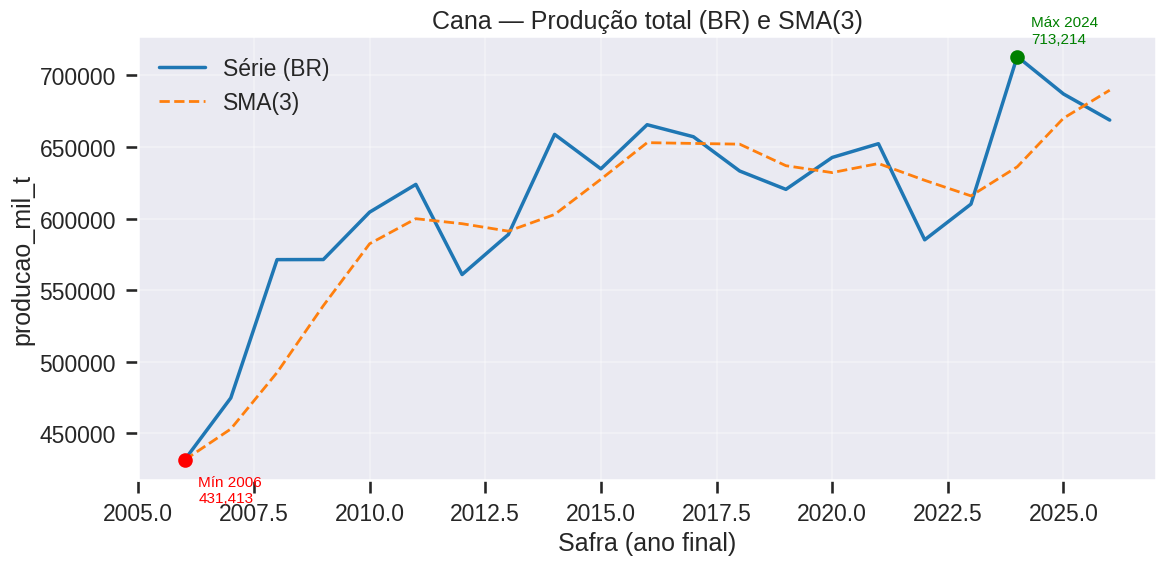

In [ ]:
# Agregar BR por safra (somando UFs quando presente)
agg = df.groupby("safra_fim", dropna=True)[col_prod].sum().sort_index()
serie_br = agg.copy()
sma3 = serie_br.rolling(3, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(serie_br.index, serie_br.values, label="Série (BR)", color="#1f77b4", linewidth=2.5)
ax.plot(sma3.index, sma3.values, label="SMA(3)", color="#ff7f0e", linestyle="--", linewidth=2)

# Anotar máximos/mínimos
max_y, max_x = serie_br.max(), serie_br.idxmax()
min_y, min_x = serie_br.min(), serie_br.idxmin()
ax.scatter([max_x],[max_y], color="green", zorder=5)
ax.scatter([min_x],[min_y], color="red", zorder=5)
ax.annotate(f"Máx {int(max_x)}\n{max_y:,.0f}", (max_x, max_y), xytext=(10,10), textcoords="offset points", fontsize=11, color="green")
ax.annotate(f"Mín {int(min_x)}\n{min_y:,.0f}", (min_x, min_y), xytext=(10,-30), textcoords="offset points", fontsize=11, color="red")

ax.set_title(f"{serie.title()} — Produção total (BR) e SMA(3)")
ax.set_xlabel("Safra (ano final)")
ax.set_ylabel(col_prod)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretação do gráfico

A linha azul mostra a evolução da produção nacional ao longo das safras. Nota-se que há oscilações visíveis, mas também um crescimento expressivo a partir do mínimo de 2006 até alcançar o pico em 2024. Essas variações podem estar ligadas a fatores climáticos, variação de área plantada ou políticas agrícolas.

A linha laranja tracejada corresponde à média móvel de 3 safras. Ela suaviza os altos e baixos pontuais e ajuda a perceber a tendência mais geral, que é de crescimento, ainda que com alguns períodos de estabilização e queda intermediária.

Os pontos destacados em vermelho e verde marcam os extremos da série. O mínimo de 2006 mostra um patamar inicial baixo de produção, enquanto o máximo de 2024 evidencia um ganho histórico. Essa diferença ilustra a magnitude da expansão do setor ao longo do período.

Em resumo, o gráfico evidencia uma trajetória de aumento da produção com oscilações intermediárias. A média móvel confirma o crescimento consistente, embora com momentos de desaceleração, e os pontos de mínimo e máximo servem como marcos importantes para entender os limites atingidos até aqui.


## Visualização 2 - Top 5 UFs por contribuição (área empilhada)
**Objetivo:** Destacar os estados que mais pesam na produção e sua dinâmica relativa.  
**Gráfico:** Área empilhada dos **Top 5 UFs** por produção total acumulada no período.  
**Legenda/Dimensões:** Eixo X = `safra_fim`; Eixo Y = produção (coluna escolhida); Cor = UF.


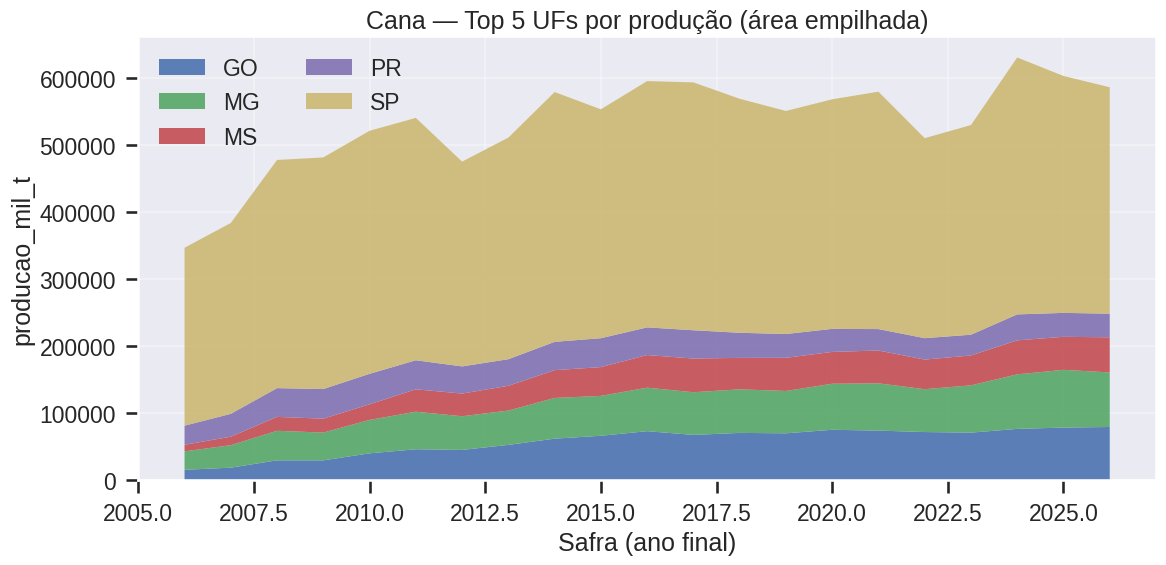

In [ ]:
col_uf = next((c for c in df.columns if c.lower() in ["uf","estado","sigla_uf"]), None)

if col_uf is None:
    display(Markdown("> **Aviso:** Não há coluna de UF/Estado claramente identificada; pulando esta visualização."))
else:
    by_uf = df.groupby([col_uf])[col_prod].sum().sort_values(ascending=False)
    top5 = list(by_uf.head(5).index)
    pivot = (df[df[col_uf].isin(top5)]
             .groupby(["safra_fim", col_uf])[col_prod]
             .sum()
             .unstack(col_uf)
             .sort_index())
    pivot = pivot.fillna(0)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.stackplot(pivot.index, pivot.values.T, labels=pivot.columns, alpha=0.9)
    ax.set_title(f"{serie.title()} — Top 5 UFs por produção (área empilhada)")
    ax.set_xlabel("Safra (ano final)")
    ax.set_ylabel(col_prod)
    ax.legend(loc="upper left", ncols=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Interpretação do gráfico de área empilhada

O gráfico mostra os cinco estados que mais produzem cana no Brasil, acumulados ao longo das safras. A cor amarela, correspondente a São Paulo, domina claramente a série, indicando que o estado é de longe o maior produtor. Essa liderança se mantém em todo o período, ainda que com oscilações, reforçando a centralidade paulista na cadeia da cana.

Os outros estados aparecem em faixas menores, mas crescentes. Goiás e Minas Gerais chamam atenção pelo aumento gradual de participação, sugerindo expansão de área ou ganhos de produtividade. Mato Grosso do Sul também apresenta crescimento, consolidando-se como parte do grupo mais relevante. O Paraná, embora presente entre os cinco, tem peso mais modesto e estável.

A forma do empilhamento evidencia que o crescimento total da produção nacional não se deve apenas a São Paulo, mas também à diversificação para outros estados. Ainda assim, a dependência da produção paulista permanece como traço marcante da série. Isso levanta questões importantes: até que ponto essa concentração em São Paulo pode ser um risco, e como a expansão em outros estados pode mudar o equilíbrio regional no futuro?


## Visualização 3 - Indicadores Técnicos sobre a série total

Como reforço visual (com cautela interpretativa em dados não-financeiros), aplicamos três indicadores sobre a série total BR:

1. **EMA(5) — Média Móvel Exponencial curta**  
   A EMA é uma média móvel que atribui pesos maiores aos valores mais recentes, diminuindo exponencialmente a importância dos pontos mais antigos. Isso a torna mais sensível a mudanças recentes do que a média móvel simples.  
   - Interpretação: em dados de produção, a EMA(5) ajuda a perceber rapidamente quando há aceleração ou desaceleração em curto prazo, sem perder totalmente a noção da tendência.

2. **Bandas de Bollinger (5, 2σ)**  
   As Bandas de Bollinger consistem em três linhas: a média móvel central (aqui de 5 pontos) e duas bandas calculadas como essa média mais ou menos duas vezes o desvio-padrão da série. Quanto maior a dispersão dos dados, mais largas ficam as bandas.  
   - Interpretação: bandas estreitas indicam estabilidade e baixa volatilidade; bandas alargadas sugerem maior variabilidade entre safras. Isso nos ajuda a identificar períodos de maior ou menor consistência na produção.

3. **MACD (12–26) e Linha de Sinal (9)**  
   O MACD (Moving Average Convergence Divergence) mede a diferença entre duas EMAs, uma rápida (12 períodos) e uma lenta (26 períodos). O resultado é comparado a uma linha de sinal, que é a média exponencial de 9 períodos do próprio MACD. Além disso, costuma-se visualizar um histograma que mostra a distância entre o MACD e a linha de sinal.  
   - Interpretação: quando o MACD cruza acima da linha de sinal, entende-se que a tendência de crescimento está ganhando força; quando cruza para baixo, que o ritmo está enfraquecendo. Em dados agrícolas, isso pode ser lido como uma forma visual de captar mudanças de fôlego na produção, ainda que não seja uma previsão no sentido econômico-financeiro.

> Conclusão: esses três indicadores, usados em conjunto, oferecem uma forma de enxergar o comportamento da série com mais nuances. Eles evidenciam não apenas a direção geral da produção, mas também sua intensidade e sua variabilidade ao longo do tempo.


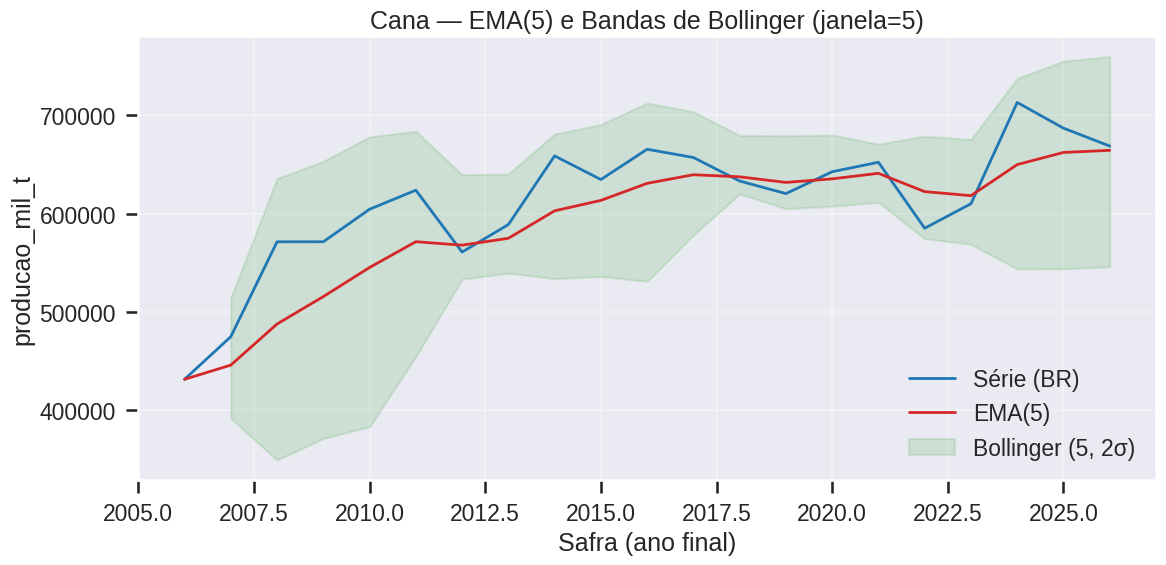

In [ ]:
# EMA(5) + Bandas de Bollinger (5, 2σ)
s = serie_br.copy()
ema5 = s.ewm(span=5, adjust=False).mean()
win = 5
ma = s.rolling(win, min_periods=1).mean()
std = s.rolling(win, min_periods=1).std()
upper = ma + 2*std
lower = ma - 2*std

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(s.index, s.values, label="Série (BR)", color="#1f77b4", linewidth=2)
ax.plot(ema5.index, ema5.values, label="EMA(5)", color="#d62728", linewidth=2)
ax.fill_between(s.index, lower, upper, color="#2ca02c", alpha=0.15, label="Bollinger (5, 2σ)")
ax.set_title(f"{serie.title()} — EMA(5) e Bandas de Bollinger (janela={win})")
ax.set_xlabel("Safra (ano final)")
ax.set_ylabel(col_prod)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretação do gráfico com EMA(5) e Bandas de Bollinger

O gráfico apresenta a série histórica da produção de cana em azul, acompanhada pela média móvel exponencial de 5 safras em vermelho e pelo envelope das Bandas de Bollinger em verde.

A EMA(5) acompanha de perto a série original, mas com uma linha mais suavizada. Essa suavização deixa claro que a tendência geral é de crescimento ao longo do período, ainda que com alguns momentos de queda ou estagnação. A EMA funciona como um guia para identificar se a trajetória recente é de alta, de baixa ou de estabilidade.

As Bandas de Bollinger oferecem outra perspectiva. Quando o intervalo verde se alarga, significa que a variabilidade da produção entre safras está maior, ou seja, a série passa por momentos mais voláteis. Quando as bandas se estreitam, a produção se mostra mais estável. Observa-se que nos anos iniciais as bandas eram bem largas, sugerindo maior incerteza ou irregularidade, e que ao longo do tempo a largura foi diminuindo, com alguns períodos mais estreitos e outros novamente mais abertos, como perto de 2024.

Em conjunto, a EMA e as Bandas de Bollinger ajudam a perceber não apenas para onde a produção caminha, mas também o quão estável ou instável foi essa trajetória. A leitura é que a cana segue uma tendência de expansão, embora sujeita a oscilações significativas em certos ciclos, sinalizadas pelo alargamento das bandas.


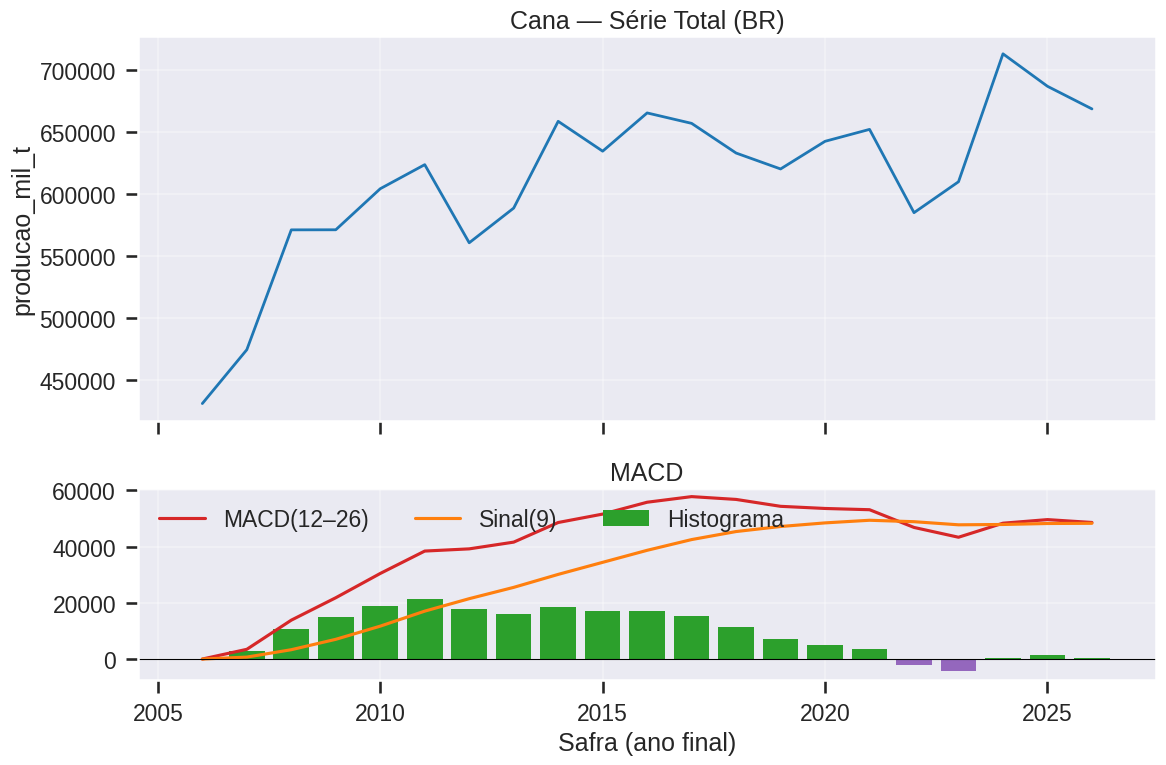

In [ ]:
# MACD (12–26) + Sinal (9)
ema12 = s.ewm(span=12, adjust=False).mean()
ema26 = s.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
hist = macd - signal

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True,
                               gridspec_kw={"height_ratios":[2,1]})

ax1.plot(s.index, s.values, label="Série (BR)", color="#1f77b4", linewidth=2)
ax1.set_title(f"{serie.title()} — Série Total (BR)")
ax1.set_ylabel(col_prod)
ax1.grid(True, alpha=0.3)

ax2.plot(macd.index, macd.values, label="MACD(12–26)", color="#d62728")
ax2.plot(signal.index, signal.values, label="Sinal(9)", color="#ff7f0e")
ax2.bar(hist.index, hist.values, label="Histograma", color=np.where(hist>=0, "#2ca02c", "#9467bd"))
ax2.axhline(0, color="black", linewidth=0.8)
ax2.set_title("MACD")
ax2.set_xlabel("Safra (ano final)")
ax2.legend(loc="upper left", ncols=3)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretação do gráfico com MACD

O gráfico superior mostra a série histórica da produção de cana no Brasil. Logo abaixo, temos o painel do MACD, um indicador que compara duas médias móveis exponenciais de períodos diferentes para revelar mudanças de ritmo na série.

A linha vermelha representa o MACD, que é a diferença entre a média curta (12 safras) e a longa (26 safras). A linha laranja é a linha de sinal, uma suavização de 9 safras do próprio MACD. O histograma, em verde ou roxo, indica a distância entre o MACD e a linha de sinal: barras positivas sugerem que a tendência de alta está mais forte, e barras negativas indicam perda de fôlego.

Observando o gráfico, nota-se que entre 2007 e 2015 o histograma é amplamente positivo, refletindo um período de expansão acelerada da produção. A partir de meados da década de 2010 o MACD começa a se aproximar da linha de sinal, e o histograma vai diminuindo, o que sugere desaceleração do crescimento. Em torno de 2021 chegam a aparecer barras negativas, sinalizando um momento de enfraquecimento. Já próximo a 2024, o histograma volta a ser levemente positivo, mas sem o mesmo vigor da fase inicial de expansão.

O MACD ajuda a visualizar as mudanças de intensidade no crescimento da produção. Ele confirma a forte aceleração inicial, mostra depois uma estabilização com perda de força e aponta que os movimentos mais recentes têm sido menos intensos, ainda que positivos.


## Análise e Principais Descobertas

- **Tendência de longo prazo:**  
  A série de produção mostra uma trajetória claramente ascendente desde meados da década de 2000, mas marcada por ciclos de aceleração e desaceleração. A SMA(3) suaviza essas oscilações e revela períodos de crescimento contínuo seguidos de fases de acomodação. Já a EMA(5), mais responsiva, capta inflexões recentes com maior clareza, destacando quando a produção começa a perder ou ganhar ritmo em horizontes curtos.

- **Volatilidade relativa:**  
  As Bandas de Bollinger indicam variações significativas na estabilidade da produção. Em alguns períodos as bandas se alargam, sugerindo maior incerteza ou choques externos (como condições climáticas adversas, oscilações de mercado ou mudanças no perfil de colheita). Em outros momentos, as bandas se estreitam, caracterizando safras mais consistentes e previsíveis. Esse padrão mostra que a expansão não se deu de forma linear, mas em meio a fases de maior e menor regularidade.

- **Mudanças de momentum:**  
  O MACD mostra que a fase de forte aceleração entre 2007 e 2015 foi sucedida por um período de arrefecimento, quando o indicador se aproximou da linha de sinal e o histograma reduziu sua intensidade. Por volta de 2021, aparecem barras negativas, sinalizando enfraquecimento do crescimento. Em seguida, nota-se uma recuperação até 2024, embora sem a mesma força da expansão inicial. Isso sugere que a produção atingiu um novo patamar, mas com dinâmica menos explosiva.

- **Contribuição regional (Top 5 UFs):**  
  O gráfico empilhado evidencia a predominância de São Paulo, que se mantém como principal estado produtor durante todo o período analisado. Contudo, também destaca a ascensão gradual de Goiás, Minas Gerais e Mato Grosso do Sul, que ampliam sua participação e reduzem a dependência absoluta do polo paulista. Essa redistribuição relativa indica um processo de interiorização da produção, com implicações logísticas, econômicas e ambientais.

Em conjunto, os indicadores mostram que a cana no Brasil passou por uma fase inicial de forte crescimento, alcançou um pico recente e agora apresenta oscilações em torno de um patamar elevado. A tendência de longo prazo ainda é de expansão, mas com maior complexidade regional e maior variabilidade nas últimas safras.


In [ ]:
out = []

# max/min
out.append(f"Máximo histórico (BR): safra {int(serie_br.idxmax())} → {serie_br.max():,.0f}")
out.append(f"Mínimo histórico (BR): safra {int(serie_br.idxmin())} → {serie_br.min():,.0f}")

# variação YoY
yoy = serie_br.pct_change()*100
maiores_altas = yoy.sort_values(ascending=False).head(3).dropna()
maiores_quedas = yoy.sort_values().head(3).dropna()

def fmt_items(s):
    return "; ".join([f"{int(k)}: {v:.1f}%" for k, v in s.items()])

out.append("Maiores altas YoY: " + fmt_items(maiores_altas))
out.append("Maiores quedas YoY: " + fmt_items(maiores_quedas))

# Top UFs acumulado
if col_uf:
    acum = df.groupby(col_uf)[col_prod].sum().sort_values(ascending=False).head(5)
    out.append("Top 5 UFs (produção acumulada): " + "; ".join([f"{k}: {v:,.0f}" for k, v in acum.items()]))

display(Markdown("**Highlights:**"))
display(Markdown("<br>".join(f"- {x}" for x in out)))


**Highlights:**

- Máximo histórico (BR): safra 2024 → 713,214<br>- Mínimo histórico (BR): safra 2006 → 431,413<br>- Maiores altas YoY: 2008: 20.3%; 2024: 16.9%; 2014: 11.9%<br>- Maiores quedas YoY: 2022: -10.3%; 2012: -10.1%; 2025: -3.7%<br>- Top 5 UFs (produção acumulada): SP: 7,114,378; MG: 1,253,890; GO: 1,214,459; MS: 809,263; PR: 799,557

## Conclusão

Este estudo transformou uma **série histórica da CONAB** em uma narrativa visual com ênfase em **tendência (SMA/EMA)**, **volatilidade relativa (Bandas de Bollinger)** e **momentum (MACD)**, além de um recorte geográfico (Top 5 UFs).  
Aprendizados:
- Séries agro **podem** se beneficiar de ferramentas visuais de análise técnica, desde que interpretadas como **sinais de regime** (e não “compra/venda”).
- A importância de um **pré-processamento robusto** (decimal pt-BR, parsing de safra) é central para evitar vieses e erros.

**Próximos passos:**
- Enriquecer com variáveis climáticas (ex.: ONI/El Niño, precipitação) para investigar relações causais.
- Testar **modelos explicativos** (regressões/ARIMA/Prophet) e **decomposição sazonal**.
- Para Café, separar **arábica vs conilon** (se disponível) e analisar especializações regionais.

**Limitações:**
- Revisões de levantamento podem introduzir duplicidades; adotamos simplificações de agregação e deduplicação.
- Unidades (“mil t”, “mil L”, “mil sacas”) variam conforme produto; mantivemos a unidade original por coluna para evitar equívocos.


## Referências e Créditos

- **Portal de Informações Agropecuárias — CONAB** (Downloads → Arquivos).  
  Página-base: https://portaldeinformacoes.conab.gov.br/download-arquivos.html  
  (Série Histórica Cana e Café confirmadas programaticamente neste notebook.)

- Bibliotecas: pandas, numpy, matplotlib, seaborn, plotly.
- [Investopedia – Exponential Moving Average (EMA)](https://www.investopedia.com/terms/e/ema.asp)
- [Investopedia – Bollinger Bands](https://www.investopedia.com/terms/b/bollingerbands.asp)
- [Investopedia – Moving Average Convergence Divergence (MACD)](https://www.investopedia.com/terms/m/macd.asp)